In [174]:
## Default imports: don't touch these
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math

In [1]:
# More Boilerplate, don't worry
%matplotlib inline
from mnist import MNIST
def load_dataset(s="data"):
    mndata = MNIST('./%s/'%s)
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    return (X_train, labels_train), (X_test, labels_test)

In [3]:
# Loaded the Libraries
(X_train, labels_train), (X_test, labels_test) = load_dataset()

# Deskewing

When we write, we often write at angles to the paper, which cause letters and numbers to be skewed. Unfortunately, unlike the human eye, computers cannot easily find similarities between images that are transformations of each other. Thus, the process of *deskewing*

Very formally, **deskewing** is the process of straightening an image that has been scanned or written crookedly — that is an image that is slanting too far in one direction, or one that is misaligned.

In particular, we model the process of deskewing as an affine transformation. We assume that when the image was created (the skewed version), it is actually some affine  skew transformation on the image $ Image' = A(Image) + b$ which we do not know. What we do know is that we want the center of mass to be the center of the image, and that we'd like to know the angle at which it was skewed.


![](https://geometrypreapteacher.wikispaces.com/file/view/skew.jpg/85225087/skew.jpg)
The methodology goes as follows:

1) Find the center of mass of the image to figure out how much we need to offset the image  
2) Find the covariance matrix of the image pixel intensities (we can use this to approximate the skew of the angle)

The function **moments** below, calculates these relevant quantities

Next, we'd like to calculate the matrix which will allow us to skew "back" to the original image

This is given by the following formula

$$\begin{bmatrix}1 & 0 \\ \alpha & 1\end{bmatrix}$$

where $\alpha = \frac{Cov(X,Y)}{Var(X)}$

Furthermore, we have an offset of $\mu - $ center


Thus, combining the two,  using the handy *interpolation* library from scipy, we complete the method **deskew** below. 

Check out the results below!

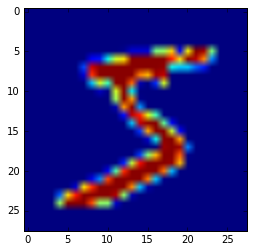

In [175]:
plt.imshow(X_train[0].reshape(28,28)) # This is what the image looks like

In [44]:
from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

In [45]:
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

In [157]:
examples = (4181, 0), (3,1), (56282, 2), (25829,3), (9741,4) , (26901,5), (50027,6), (17935,7) , (41495, 8), (14662, 9)

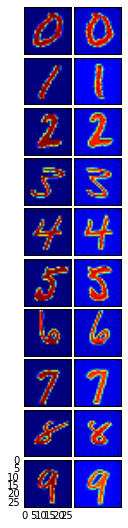

In [172]:
from mpl_toolkits.axes_grid1 import AxesGrid
grid = AxesGrid(plt.figure(figsize=(8,15)), 141,  # similar to subplot(141)
                    nrows_ncols=(10, 2),
                    axes_pad=0.05,
                    label_mode="1",
                    )

for examplenum,num in examples:
    im = grid[2*num].imshow(X_train[examplenum].reshape(28,28))
    im2 = grid[2*num+1].imshow(deskew(X_train[examplenum].reshape(28,28)))

[[ 31.80782549 -17.91061544]
 [-17.91061544  11.38495874]]


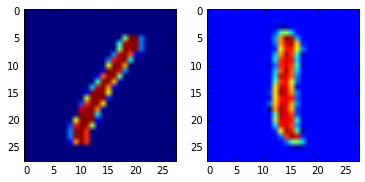

In [41]:
plt.subplot(1, 2, 1)
plt.imshow(X_train[3].reshape(28,28))

newim = deskew(X_train[3].reshape(28,28))
plt.subplot(1, 2, 2)
plt.imshow(newim)

## Results

In [39]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
import sklearn.metrics as metrics

In [37]:
def createModel(x,y):
    yp = OneHotEncoder()
    y = yp.fit_transform(y.reshape(60000,1)).toarray()
    clf = linear_model.Ridge (alpha = 0)
    clf.fit(x,y)
    return clf

def predict(model,x):
    return np.argmax(model.predict(x),axis=1)

In [38]:
model_unchanged = createModel(X_train,labels_train)

In [41]:
metrics.accuracy_score(predict(model_unchanged,X_train),labels_train)

0.85645000000000004

In [40]:
metrics.accuracy_score(predict(model_unchanged,X_test),labels_test)

0.8589

In [46]:
def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

X_train_deskewed = deskewAll(X_train)
X_test_deskewed = deskewAll(X_test)

In [47]:
model_deskewed = createModel(X_train_deskewed,labels_train)

In [49]:
metrics.accuracy_score(predict(model_deskewed,X_train_deskewed),labels_train)

0.91033333333333333

In [50]:
metrics.accuracy_score(predict(model_deskewed,X_test_deskewed),labels_test)

0.91400000000000003

# Overall Results

Using L2 Regularized Regression (Ridge Regression), we have


### Unchanged

Train Accuracy: .8564  
Test Accuracy: .8589

### Deskewed

Train Accuracy: .9103  
Test Accuracy: .9140


**Thus by using deskewed features, we automatically boost our accuracy rougly 6%! Crazy!** 